## Метод Actor-Critic

Теорема о градиенте стратегии связывает градиент целевой функции  и градиент самой стратегии:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$

Встает вопрос, как оценить $Q^\pi(s, a)$? Ранее в REINFORCE мы использовали отдачу $R_t$ (полученную методом Монте-Карло) в качестве несмещенной оценки $Q^\pi(s, a)$. В Actor-Critic же предлагается отдельно обучать нейронную сеть Q-функции - критика.

Актор-критиком часто называют обобщенный фреймворк (подход), нежели какой-то конкретный алгоритм. Как подход актор-критик не указывает, каким конкретно [policy gradient] методом обучается актор и каким [value based] методом обучается критик. Таким образом актор-критик задает целое семейство различных алгоритмов.

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gymnasium as gym
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Основной цикл

In [ ]:
def print_mean_reward(step, episode_rewards):
    if not episode_rewards:
        return

    t = min(50, len(episode_rewards))
    mean_reward = sum(episode_rewards[-t:]) / t
    print(f"step: {str(step).zfill(6)}, mean reward: {mean_reward:.2f}")
    return mean_reward


def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    if isinstance(x, list) and isinstance(x[0], torch.Tensor):
        return torch.asarray(x).to(device)

    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x).to(device)
    return x


def run(
        env: gym.Env, hidden_size: int, actor_lr: float, critic_lr: float, gamma: float, max_episodes: int,
        rollout_size: int, replay_buffer_size: int, critic_batch_size: int, critic_updates_per_actor: int
):
    # Инициализируем агента
    states_dim = env.observation_space.shape[0]
    actions_dim = env.action_space.n
    agent = ActorCriticAgent(states_dim, actions_dim, hidden_size, actor_lr, critic_lr, gamma, replay_buffer_size)

    step = 0
    episode_rewards = []
    episode_mean_rewards = []

    for i_episode in range(1, max_episodes + 1):
        cumulative_reward = 0
        done = False
        state, _ = env.reset()

        while not done:
            step += 1

            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.append_to_replay_buffer(state, action, reward, next_state, done)
            state = next_state
            cumulative_reward += reward

        episode_rewards.append(cumulative_reward)

        # выполняем обновление
        if agent.update(rollout_size, critic_batch_size, critic_updates_per_actor):
            mean_reward = print_mean_reward(step, episode_rewards)
            episode_mean_rewards.append(mean_reward)
            if mean_reward >= 200:
                print('Принято!')
                return episode_mean_rewards
            episode_rewards = []
    return episode_mean_rewards

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from collections import deque, namedtuple

class ActorBatch:
    def __init__(self):
        self.logprobs = []
        self.q_values = []

    def append(self, log_prob, q_value):
        self.logprobs.append(log_prob)
        self.q_values.append(q_value)

    def clear(self):
        self.logprobs.clear()
        self.q_values.clear()


Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def append(self, state, action, reward, next_state, done):
        sample = Transition(state, action, reward, next_state, done)
        self.buffer.append(sample)

    def sample_batch(self, n_samples):
        indices = np.random.choice(len(self.buffer), n_samples)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            s, a, r, n_s, done = self.buffer[i]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(n_s)
            dones.append(done)

        batch = np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
        return batch

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
        )

    def forward(self, state):
        state = to_tensor(state)
        return self.net(state)


class ActorCriticModel(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()

        # Инициализируем сеть агента с двумя головами: softmax-актора и линейного критика
        self.net = MLPModel(state_dim, action_dim, hidden_dim).to(device)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
        )

    def forward(self, state):
        hidden_state = self.net(state)
        # Вычислить выбранное действие, логарифм вероятности его выбора и соответствующее значение Q-функции
        action_probs = self.actor_head(hidden_state)
        dist = Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)
        action = action.item()

        q_value = self.critic_head(hidden_state)[action]

        return action, log_prob, q_value

    def evaluate(self, state):
        # Вычислить значения Q-функции для данного состояния
        hidden_state = self.net(state)
        q_values = self.critic_head(hidden_state)
        return q_values


class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_size, actor_lr, critic_lr, gamma, replay_buffer_size):
        self.gamma = gamma

        # Инициализируем модель актор-критика и SGD оптимизатор
        self.actor_critic = ActorCriticModel(state_dim, hidden_size, action_dim).to(device)
        self.opt_actor = torch.optim.Adam(self.actor_critic.parameters(), lr=actor_lr)
        self.opt_critic = torch.optim.Adam(self.actor_critic.parameters(), lr=critic_lr)

        self.actor_batch = ActorBatch()
        self.replay_buffer = ReplayBuffer(replay_buffer_size)

    def act(self, state):
        # Произвести выбор действия и сохранить необходимые данные в батч для последующего обучения
        # Не забыть сделать q_value.detach()
        action, logprob, q_value = self.actor_critic(state)
        self.actor_batch.append(logprob, q_value.detach())
        return action

    def evaluate(self, state):
        return self.actor_critic.evaluate(state)

    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return False

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)
        self.actor_batch.clear()
        return True

    def update_actor(self):
        q_values = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs).to(device)

        # Реализовать шаг обновления актора.
        # Нормализация полезностей
        q_values = (q_values - q_values.mean()) / (q_values.std() + 1e-7)
        # Вычислить ошибку `loss`
        loss = - logprobs * q_values
        loss = loss.mean()

        self.opt_actor.zero_grad()
        loss.backward()
        self.opt_actor.step()

    def update_critic(self, batch_size, critic_updates_per_actor):
        # ограничивает сверху количество эпох для буфера небольшого размера
        critic_updates_per_actor = min(
            critic_updates_per_actor,
            5 * len(self.replay_buffer.buffer) // batch_size
        )

        for _ in range(critic_updates_per_actor):
            train_batch = self.replay_buffer.sample_batch(batch_size)
            states, actions, rewards, next_states, is_done = train_batch

            self.opt_critic.zero_grad()
            loss, _ = self.compute_td_loss(states, actions, rewards, next_states, is_done, regularizer=0.01)
            loss.backward()
            self.opt_critic.step()

    def append_to_replay_buffer(self, s, a, r, next_s, done):
        # Добавьте новый экземпляр данных в память прецедентов.
        self.replay_buffer.append(s, a, r, next_s, done)

    def compute_td_loss(
        self, states, actions, rewards, next_states, is_done, check_shapes=False, regularizer=0.0
    ):
        """ Считатет td ошибку, используя лишь операции фреймворка torch"""

        # переводим входные данные в тензоры
        states = to_tensor(states)                      # shape: [batch_size, state_size]
        actions = to_tensor(actions, int).long()        # shape: [batch_size]
        rewards = to_tensor(rewards)                    # shape: [batch_size]
        next_states = to_tensor(next_states)            # shape: [batch_size, state_size]
        is_done = to_tensor(is_done, bool)              # shape: [batch_size]

        # получаем значения q для всех действий из текущих состояний
        predicted_qvalues = self.evaluate(states)

        # получаем q-values для выбранных действий
        predicted_qvalues_for_actions = predicted_qvalues[range(states.shape[0]), actions]

        with torch.no_grad():
            predicted_next_qvalues = self.evaluate(next_states)
            next_state_values = torch.max(predicted_next_qvalues, axis=-1)[0]

            assert next_state_values.dtype == torch.float32

            # вычисляем target q-values для функции потерь
            target_qvalues_for_actions = rewards + self.gamma * next_state_values

            # для последнего действия в эпизоде используем
            # упрощенную формулу Q(s,a) = r(s,a),
            # т.к. s' для него не существует
            target_qvalues_for_actions = torch.where(is_done, rewards, target_qvalues_for_actions)

        losses = (predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2

        # MSE loss для минимизации
        loss = torch.mean(losses)
        # добавляем регуляризацию на значения Q
        loss += regularizer * predicted_qvalues_for_actions.mean()

        return loss, losses

In [ ]:
from gymnasium.wrappers.time_limit import TimeLimit
env_name = "CartPole-v1"

episode_mean_rewards = run(
    env = TimeLimit(gym.make(env_name), 500),
    max_episodes = 50000,  # количество эпизодов обучения
    hidden_size = 64,  # кол-во переменных в скрытых слоях
    rollout_size = 1000,  # через столько шагов стратегия будет обновляться
    actor_lr = 0.01,
    critic_lr = 0.01,
    gamma = 0.99,  # дисконтирующий множитель,
    replay_buffer_size = 20000,
    critic_batch_size = 512,
    critic_updates_per_actor = 32,
)

step: 001022, mean reward: 27.62
step: 002024, mean reward: 12.90
step: 003028, mean reward: 10.60
step: 004037, mean reward: 10.02
step: 005037, mean reward: 9.66
step: 006040, mean reward: 10.68
step: 007051, mean reward: 17.12
step: 008057, mean reward: 13.98
step: 009057, mean reward: 11.04
step: 010124, mean reward: 46.39
step: 011125, mean reward: 32.29
step: 012135, mean reward: 30.61
step: 013135, mean reward: 43.48
step: 014161, mean reward: 36.64
step: 015215, mean reward: 70.27
step: 016226, mean reward: 38.88
step: 017252, mean reward: 51.30
step: 018287, mean reward: 258.75
Принято!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


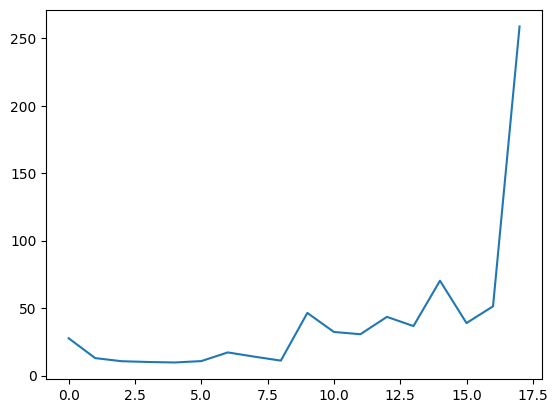

In [ ]:
import matplotlib.pyplot as plt
plt.plot(episode_mean_rewards)
plt.show()

**Advantage Actor Critic**

In [13]:
class AdvantageActorCriticModel(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()

        # Инициализируем сеть агента с двумя головами: softmax-актора и линейного критика
        self.net = MLPModel(state_dim, action_dim, hidden_dim).to(device)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
        )

    def forward(self, state):
        hidden_state = self.net(state)
        # Вычислить выбранное действие, логарифм вероятности его выбора и соответствующее значение Q-функции
        action_probs = self.actor_head(hidden_state)
        dist = Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)
        action = action.item()

        q_value_full = self.critic_head(hidden_state)
        #ТУТ ДОБАВИЛИ ADVANTAGE
        q_value = q_value_full[action]
        if len(q_value_full.shape) == 2:
          v_value = torch.max(q_value_full, axis=1)
          v_value = torch.hstack([v_value.T] * q_value_full.shape[1])
        else:
          v_value = torch.max(q_value_full)
        advantage = q_value - v_value
        return action, log_prob, q_value, advantage
    def evaluate(self, state):
        # Вычислить значения Q-функции для данного состояния
        hidden_state = self.net(state)
        q_values = self.critic_head(hidden_state)
        return q_values

class AdvantageActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_size, actor_lr, critic_lr, gamma, replay_buffer_size):
        self.gamma = gamma

        # Инициализируем модель актор-критика и SGD оптимизатор
        self.actor_critic = AdvantageActorCriticModel(state_dim, hidden_size, action_dim).to(device)
        self.opt_actor = torch.optim.Adam(self.actor_critic.parameters(), lr=actor_lr)
        self.opt_critic = torch.optim.Adam(self.actor_critic.parameters(), lr=critic_lr)

        self.actor_batch = ActorBatch()
        self.replay_buffer = ReplayBuffer(replay_buffer_size)

    def act(self, state):
        # Произвести выбор действия и сохранить необходимые данные в батч для последующего обучения
        # Не забыть сделать q_value.detach()
        action, logprob, q_value, advantage = self.actor_critic(state)
        self.actor_batch.append(logprob, advantage.detach())
        return action

    def evaluate(self, state):
        return self.actor_critic.evaluate(state)

    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return False

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)
        self.actor_batch.clear()
        return True

    def update_actor(self):
        q_values = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs).to(device)

        # Реализовать шаг обновления актора.
        # Нормализация полезностей
        q_values = (q_values - q_values.mean()) / (q_values.std() + 1e-7)

        # Вычислить ошибку `loss`
        loss = - logprobs * q_values
        loss = loss.mean()

        self.opt_actor.zero_grad()
        loss.backward()
        self.opt_actor.step()

    def update_critic(self, batch_size, critic_updates_per_actor):
        # ограничивает сверху количество эпох для буфера небольшого размера
        critic_updates_per_actor = min(
            critic_updates_per_actor,
            5 * len(self.replay_buffer.buffer) // batch_size
        )

        for _ in range(critic_updates_per_actor):
            train_batch = self.replay_buffer.sample_batch(batch_size)
            states, actions, rewards, next_states, is_done = train_batch

            self.opt_critic.zero_grad()
            loss, _ = self.compute_td_loss(states, actions, rewards, next_states, is_done, regularizer=0.01)
            loss.backward()
            self.opt_critic.step()

    def append_to_replay_buffer(self, s, a, r, next_s, done):
        # Добавьте новый экземпляр данных в память прецедентов.
        self.replay_buffer.append(s, a, r, next_s, done)

    def compute_td_loss(
        self, states, actions, rewards, next_states, is_done, check_shapes=False, regularizer=0.0
    ):
        """ Считатет td ошибку, используя лишь операции фреймворка torch"""

        # переводим входные данные в тензоры
        states = to_tensor(states)                      # shape: [batch_size, state_size]
        actions = to_tensor(actions, int).long()        # shape: [batch_size]
        rewards = to_tensor(rewards)                    # shape: [batch_size]
        next_states = to_tensor(next_states)            # shape: [batch_size, state_size]
        is_done = to_tensor(is_done, bool)              # shape: [batch_size]

        # получаем значения q для всех действий из текущих состояний
        predicted_qvalues = self.evaluate(states)

        # получаем q-values для выбранных действий
        predicted_qvalues_for_actions = predicted_qvalues[range(states.shape[0]), actions]

        with torch.no_grad():
            predicted_next_qvalues = self.evaluate(next_states)
            next_state_values = torch.max(predicted_next_qvalues, axis=-1)[0]

            assert next_state_values.dtype == torch.float32

            # вычисляем target q-values для функции потерь
            target_qvalues_for_actions = rewards + self.gamma * next_state_values

            # для последнего действия в эпизоде используем
            # упрощенную формулу Q(s,a) = r(s,a),
            # т.к. s' для него не существует
            target_qvalues_for_actions = torch.where(is_done, rewards, target_qvalues_for_actions)

        losses = (predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2

        # MSE loss для минимизации
        loss = torch.mean(losses)
        # добавляем регуляризацию на значения Q
        loss += regularizer * predicted_qvalues_for_actions.mean()

        return loss, losses

In [ ]:
def run(
        env: gym.Env, hidden_size: int, actor_lr: float, critic_lr: float, gamma: float, max_episodes: int,
        rollout_size: int, replay_buffer_size: int, critic_batch_size: int, critic_updates_per_actor: int
):
    # Инициализируем агента
    states_dim = env.observation_space.shape[0]
    actions_dim = env.action_space.n
    agent = AdvantageActorCriticAgent(states_dim, actions_dim, hidden_size, actor_lr, critic_lr, gamma, replay_buffer_size)

    step = 0
    episode_rewards = []
    episode_mean_rewards = []

    for i_episode in range(1, max_episodes + 1):
        cumulative_reward = 0
        done = False
        state, _ = env.reset()

        while not done:
            step += 1

            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.append_to_replay_buffer(state, action, reward, next_state, done)
            state = next_state
            cumulative_reward += reward

        episode_rewards.append(cumulative_reward)

        # выполняем обновление
        if agent.update(rollout_size, critic_batch_size, critic_updates_per_actor):
            mean_reward = print_mean_reward(step, episode_rewards)
            episode_mean_rewards.append(mean_reward)
            if mean_reward >= 200:
                print('Принято!')
                return episode_mean_rewards
            episode_rewards = []
    return episode_mean_rewards

In [14]:
from gymnasium.wrappers.time_limit import TimeLimit
env_name = "CartPole-v1"

episode_mean_rewards = run(
    env = TimeLimit(gym.make(env_name), 500),
    max_episodes = 50000,  # количество эпизодов обучения
    hidden_size = 64,  # кол-во переменных в скрытых слоях
    rollout_size = 1000,  # через столько шагов стратегия будет обновляться
    actor_lr = 0.01,
    critic_lr = 0.01,
    gamma = 0.99,  # дисконтирующий множитель,
    replay_buffer_size = 20000,
    critic_batch_size = 512,
    critic_updates_per_actor = 32,
)

step: 001017, mean reward: 20.76
step: 002019, mean reward: 14.78
step: 003021, mean reward: 14.52
step: 004023, mean reward: 19.58
step: 005048, mean reward: 25.00
step: 006094, mean reward: 33.74
step: 007098, mean reward: 35.86
step: 008143, mean reward: 58.06
step: 009198, mean reward: 117.22
step: 010295, mean reward: 121.89
step: 011507, mean reward: 404.00
Принято!


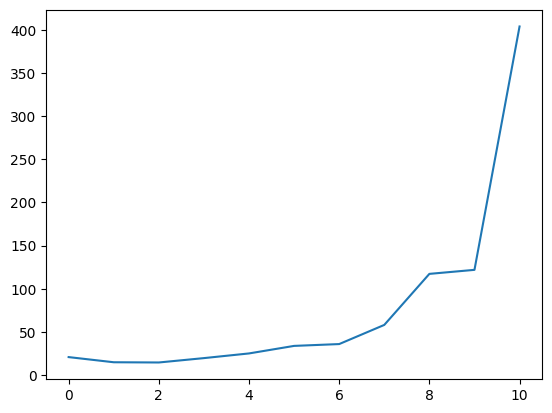

In [15]:
import matplotlib.pyplot as plt
plt.plot(episode_mean_rewards)
plt.show()